# 与信問題
## エラーもそのままにしています

# まとめ１（続く）
　
まず、数値かつ欠損値がない43変数でロジスティック回帰分析を行った。  
→ AUC = 0.59
（Kaggleにup）  　
  
その後、変数を正規化すると少し改善    
→　AUC = 0.64


In [90]:
import numpy as np #行列
import pandas as pd #データ分析
import matplotlib.pyplot as plt
import seaborn as sns #matplotlibを使いやすくしたもの
%matplotlib inline

import pandas_profiling as pdp #pandas report

# pdp.ProfileReport(df)  #分析してくれる

import cv2

In [91]:
df=pd.read_csv('input/application_train.csv')

In [92]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## 【問題1】コンペティション内容の確認
コンペティションのOverviewページ読み、「Home Credit Default Risk」について以下の観点について確認してください。  
 
何を学習し、何を予測するのか： 貸し倒れするかどうかを学習し、予測する  
どのようなファイルを作りKaggleに提出するか CSV file (ID, probability)  
提出されたものはどういった指標値で評価されるのか ROC  

# 【問題2】学習と検証
データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行してください。  

検証にはこのコンペティションで使用される評価指標を用いるようにしてください。学習に用いる手法は指定しません。

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [94]:
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [95]:
df.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [96]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [98]:
df1=df

In [99]:
y = df['TARGET']

In [100]:
len(y)

307511

In [101]:
type(y)

pandas.core.series.Series

In [102]:
y.isnull().sum()

0

In [103]:
y.mean()

0.08072881945686496

In [104]:
y = y.values

In [105]:
type(y)

numpy.ndarray

In [106]:
X = df.select_dtypes(include='number')

In [107]:
df.shape

(307511, 122)

In [108]:
X.shape

(307511, 106)

In [109]:
X.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
CNT_CHILDREN                      0
AMT_INCOME_TOTAL                  0
AMT_CREDIT                        0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 106, dtype: int64

In [110]:
X = X.dropna(how='any', axis=1)

In [111]:
X.shape

(307511, 45)

In [23]:
X.isnull().sum()

SK_ID_CURR                     0
TARGET                         0
CNT_CHILDREN                   0
AMT_INCOME_TOTAL               0
AMT_CREDIT                     0
REGION_POPULATION_RELATIVE     0
DAYS_BIRTH                     0
DAYS_EMPLOYED                  0
DAYS_REGISTRATION              0
DAYS_ID_PUBLISH                0
FLAG_MOBIL                     0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
FLAG_CONT_MOBILE               0
FLAG_PHONE                     0
FLAG_EMAIL                     0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
HOUR_APPR_PROCESS_START        0
REG_REGION_NOT_LIVE_REGION     0
REG_REGION_NOT_WORK_REGION     0
LIVE_REGION_NOT_WORK_REGION    0
REG_CITY_NOT_LIVE_CITY         0
REG_CITY_NOT_WORK_CITY         0
LIVE_CITY_NOT_WORK_CITY        0
FLAG_DOCUMENT_2                0
FLAG_DOCUMENT_3                0
FLAG_DOCUMENT_4                0
FLAG_DOCUMENT_5                0
FLAG_DOCUMENT_6                0
FLAG_DOCUM

In [24]:
X.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,0,202500.0,406597.5,0.018801,-9461,-637,-3648.0,-2120,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,270000.0,1293502.5,0.003541,-16765,-1188,-1186.0,-291,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,0,67500.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,135000.0,312682.5,0.008019,-19005,-3039,-9833.0,-2437,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,121500.0,513000.0,0.028663,-19932,-3038,-4311.0,-3458,...,0,0,0,0,0,0,0,0,0,0


In [112]:
X = X.drop('SK_ID_CURR', axis=1)

In [113]:
X = X.drop('TARGET', axis=1)

In [114]:
X.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,0,202500.0,406597.5,0.018801,-9461,-637,-3648.0,-2120,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,270000.0,1293502.5,0.003541,-16765,-1188,-1186.0,-291,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,67500.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,135000.0,312682.5,0.008019,-19005,-3039,-9833.0,-2437,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,121500.0,513000.0,0.028663,-19932,-3038,-4311.0,-3458,1,1,...,0,0,0,0,0,0,0,0,0,0


In [28]:
X = X.values

In [29]:
type(X)

numpy.ndarray

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
test_size=0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

In [32]:
len(X)

307511

In [33]:
len(X_train)

230633

In [34]:
from sklearn.preprocessing import StandardScaler

In [35]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_transform = scaler.transform(X_train)
X_test_transform = scaler.transform(X_test)

In [ ]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train_transform, y_train) 

In [49]:
from sklearn.tree import DecisionTreeClassifier
dtc=DecisionTreeClassifier()
dtc.fit(X_train_transform, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()
rfc.fit(X_train_transform, y_train) 

In [60]:
from sklearn.linear_model import LogisticRegression

lreg=LogisticRegression()
lreg.fit(X_train_transform, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
X_train_transform.shape

(230633, 43)

In [46]:
y_train.shape

(230633,)

In [ ]:
y_train

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
nn = KNeighborsClassifier()
nn.fit(X_train_transform, y_train) 

In [ ]:
nn.score(X_train_transform, y_train) 

In [32]:
X.shape

(307511, 106)

In [ ]:
nn.score(X_test_trandfom, y_test) 

In [32]:
X.shape

(307511, 106)

In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [50]:
dtc_predict = dtc.predict(X_test_transform)

In [51]:
dtc_predict

array([0, 0, 0, ..., 0, 0, 0])

In [56]:
accuracy_score(y_test, dtc_predict )

0.8422565623455345

In [52]:
precision_score(y_test, dtc_predict )

0.1072432721917258

In [53]:
recall_score(y_test, dtc_predict )

0.12795527156549522

In [54]:
f1_score(y_test, dtc_predict )

0.11668730424648555

In [55]:
confusion_matrix(y_test,dtc_predict )

array([[63950,  6668],
       [ 5459,   801]])

In [58]:
lreg_predict  = lreg.predict_proba(X_test_transform)

In [61]:
lreg_predict

array([0, 0, 0, ..., 0, 0, 0])

In [62]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) # 50%のデータを学習データに、50%を検証データにする

lr = LogisticRegression() # ロジスティック回帰モデルのインスタンスを作成
lr.fit(X_train, y_train) # ロジスティック回帰モデルの重みを学習

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [63]:
print("coefficient = ", lr.coef_)
print("intercept = ", lr.intercept_)

coefficient =  [[-8.37691140e-08 -6.42296012e-07 -3.37353802e-07 -3.26235041e-09
   1.10102632e-04  1.08789082e-06  2.92955899e-05  1.15047852e-04
  -7.83480500e-08 -7.73237555e-08 -4.79244945e-10 -7.78501284e-08
  -5.08815967e-08 -1.65796798e-08 -4.65083689e-08 -4.18592595e-08
  -1.41656003e-06 -1.96910442e-09 -4.35797285e-09 -3.72340275e-09
   1.31767295e-08  2.04389877e-08  1.38640469e-08  2.07251636e-10
   3.79093470e-08 -8.33295936e-11 -3.73780148e-09  2.71900985e-09
  -1.96890181e-10 -2.25189159e-08 -1.35786738e-09 -2.84280825e-11
  -3.93453208e-09 -8.35515352e-12 -3.64761217e-09 -2.94473759e-09
  -1.05134709e-09 -5.52477818e-09 -2.42227593e-10 -7.02933303e-09
  -2.05037857e-10 -1.15572199e-10 -1.27097095e-10]]
intercept =  [-7.83640213e-08]


In [64]:
probs = lr.predict_proba(X_test)
print(probs)

[[0.96394325 0.03605675]
 [0.94617741 0.05382259]
 [0.95364466 0.04635534]
 ...
 [0.97140569 0.02859431]
 [0.93247238 0.06752762]
 [0.9629675  0.0370325 ]]


In [66]:
len(probs)

92254

In [69]:
probs.shape

(92254, 2)

In [70]:
type(probs)

numpy.ndarray

In [71]:
probs

array([[0.96394325, 0.03605675],
       [0.94617741, 0.05382259],
       [0.95364466, 0.04635534],
       ...,
       [0.97140569, 0.02859431],
       [0.93247238, 0.06752762],
       [0.9629675 , 0.0370325 ]])

In [73]:
probs[:, 0]

array([0.96394325, 0.94617741, 0.95364466, ..., 0.97140569, 0.93247238,
       0.9629675 ])

In [67]:
len(y_test)

92254

In [77]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

#roc = roc_curve(y_true, y_score)
fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])

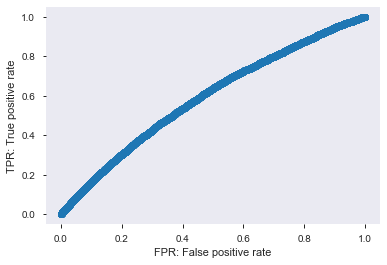

In [78]:
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

In [79]:
from sklearn.metrics import roc_auc_score
import numpy as np

print(roc_auc_score(y_test, probs[:, 1]))

0.5916091494783084


In [80]:
df_test=pd.read_csv('input/application_test.csv')

In [82]:
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
df_test.shape

(48744, 121)

In [84]:
K = df_test.select_dtypes(include='number')

In [85]:
K = K.drop('SK_ID_CURR', axis=1)

In [86]:
K.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,-5170.0,-812,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,-9118.0,-1623,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458,-2175.0,-3503,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866,-2000.0,-4208,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191,-4000.0,-4262,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
K = K.dropna(how='any', axis=1)

In [89]:
K.shape

(48744, 46)

In [115]:
X.shape

(307511, 43)

In [117]:
index = X.columns

In [119]:
K = K[index]

In [120]:
K.shape

(48744, 43)

In [121]:
K = K.values

In [122]:
probs = lr.predict_proba(K)
print(probs)

[[0.93367232 0.06632768]
 [0.92997776 0.07002224]
 [0.95398396 0.04601604]
 ...
 [0.90415604 0.09584396]
 [0.88462245 0.11537755]
 [0.90439941 0.09560059]]


In [123]:
len(probs)

48744

In [124]:
L=df_test['SK_ID_CURR']

In [125]:
len(L)

48744

In [126]:
L

0        100001
1        100005
2        100013
3        100028
4        100038
          ...  
48739    456221
48740    456222
48741    456223
48742    456224
48743    456250
Name: SK_ID_CURR, Length: 48744, dtype: int64

In [132]:
type(L)

numpy.ndarray

In [128]:
type(K)

numpy.ndarray

In [131]:
L=L.values

In [135]:
L.shape

(48744,)

In [134]:
np.hstack([L, K])

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [136]:
LL=L.T

In [137]:
KK=K.T

In [138]:
LL

array([100001, 100005, 100013, ..., 456223, 456224, 456250])

In [139]:
L

array([100001, 100005, 100013, ..., 456223, 456224, 456250])

In [140]:
LL.shape

(48744,)

In [142]:
L=L.reshape(48744, 1)

In [144]:
KK = probs.reshape(48744, 1)

ValueError: cannot reshape array of size 97488 into shape (48744,1)

In [145]:
len(probs)

48744

In [146]:
type(probs)

numpy.ndarray

In [147]:
probs.shape

(48744, 2)

In [150]:
KK = probs[:, 1]

In [151]:
KK

array([0.06632768, 0.07002224, 0.04601604, ..., 0.09584396, 0.11537755,
       0.09560059])

In [153]:
KK.shape

(48744,)

In [155]:
KK=KK.reshape(48744, 1)

In [158]:
LL=LL.reshape(48744, 1)

In [157]:
KK

array([[0.06632768],
       [0.07002224],
       [0.04601604],
       ...,
       [0.09584396],
       [0.11537755],
       [0.09560059]])

In [159]:
LL

array([[100001],
       [100005],
       [100013],
       ...,
       [456223],
       [456224],
       [456250]])

In [164]:
A=np.hstack([LL, KK])

In [165]:
A

array([[1.00001000e+05, 6.63276783e-02],
       [1.00005000e+05, 7.00222433e-02],
       [1.00013000e+05, 4.60160409e-02],
       ...,
       [4.56223000e+05, 9.58439647e-02],
       [4.56224000e+05, 1.15377548e-01],
       [4.56250000e+05, 9.56005891e-02]])

In [173]:
B = A[:, 0].astype('int')

In [175]:
B= A[:, 1]

In [176]:
B

array([0.06632768, 0.07002224, 0.04601604, ..., 0.09584396, 0.11537755,
       0.09560059])

In [177]:
B.to_csv("result.csv")

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [178]:
np.savetxt('result.csv',B,delimiter=',')

In [179]:
len(X)

307511

In [180]:
len(y)

307511

In [182]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) # 50%のデータを学習データに、50%を検証データにする

lr = LogisticRegression(normalize=True) # ロジスティック回帰モデルのインスタンスを作成
lr.fit(X_train, y_train) # ロジスティック回帰モデルの重みを学習

TypeError: __init__() got an unexpected keyword argument 'normalize'

In [181]:
from sklearn.model_selection import GridSearchCV

In [183]:
from sklearn import linear_model
clf = linear_model.LinearRegression()

In [184]:

from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # 50%のデータを学習データに、50%を検証データにする

scaler = StandardScaler()
scaler.fit(X_train)
X_train_transform = scaler.transform(X_train)
X_test_transform = scaler.transform(X_test)

lr = LogisticRegression() # ロジスティック回帰モデルのインスタンスを作成
lr.fit(X_train_transform, y_train) # ロジスティック回帰モデルの重みを学習


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [186]:
probs = lr.predict_proba(X_test_transform)
print(probs)

[[0.91805052 0.08194948]
 [0.94378295 0.05621705]
 [0.96551496 0.03448504]
 ...
 [0.91906778 0.08093222]
 [0.8667381  0.1332619 ]
 [0.90215748 0.09784252]]


In [187]:
fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])

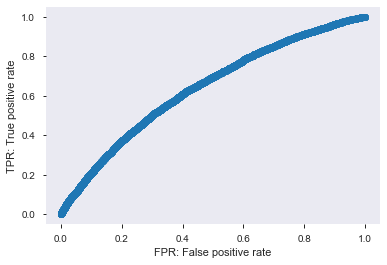

In [188]:
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

In [189]:
from sklearn.metrics import roc_auc_score
import numpy as np

print(roc_auc_score(y_test, probs[:, 1]))

0.6400871204777555
